# Smart Factory Energy Prediction Challenge

## Problem Overview
The goal is to develop a machine learning model to accurately predict the energy consumption of industrial equipment (`equipment_energy_consumption`) based on sensor data from a manufacturing facility. This will help optimize operations for energy efficiency and cost reduction.

## Objectives
1. Analyze sensor data to identify patterns and relationships.
2. Build a robust regression model.
3. Evaluate model performance using RMSE, MAE, and R².
4. Provide actionable insights and recommendations.
5. Determine the utility of `random_variable1` and `random_variable2`.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Format floats to 3 decimal places
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Inspect Data

In [2]:
# Load the dataset
try:
    df = pd.read_csv('data/data.csv')
except FileNotFoundError:
    print("Error: 'data/data.csvdata.csv' not found. Please ensure the data file is in the correct path.")
    
    exit()


print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
display(df.describe(include='all'))

Dataset Shape: (16857, 29)

First 5 rows of the dataset:


,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,zone5_temperature,zone5_humidity,zone6_temperature,zone6_humidity,zone7_temperature,zone7_humidity,zone8_temperature,zone8_humidity,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790,19.790,NaN,19.000,45.567,17.167,55.200,NaN,84.257,17.200,41.627,18.200,48.900,17.033,45.530,6.600,733.500,92.000,7.000,63.000,5.300,13.275,13.275
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722,19.790,44.790,19.000,45.992,17.167,55.200,6.833,84.063,17.200,NaN,18.200,48.863,17.067,45.560,6.483,733.600,92.000,6.667,59.167,5.200,18.606,18.606
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.627,19.790,44.933,35.921,45.890,NaN,55.090,6.560,83.157,17.200,41.433,18.200,48.730,17.000,45.500,6.367,733.700,92.000,6.333,55.333,5.100,28.643,28.643
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590,19.790,45.000,NaN,45.723,17.167,55.090,6.433,83.423,17.133,41.290,18.100,94.386,17.000,45.400,6.250,733.800,92.000,6.000,51.500,37.674,45.410,45.410
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530,19.790,45.000,18.890,45.530,17.200,55.090,6.367,84.893,17.200,41.230,18.100,48.590,4.477,45.400,6.133,733.900,92.000,5.667,47.667,4.900,10.084,10.084



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null 

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,zone4_humidity,zone5_temperature,zone5_humidity,zone6_temperature,zone6_humidity,zone7_temperature,zone7_humidity,zone8_temperature,zone8_humidity,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
count,16857,16013,16048,15990,16056,16004,15990.000,16055.000,15979.000,16041.000,16076.000,16019.000,16056.000,16009.000,16010.000,16063.000,16052.000,16009.000,16080.000,16084.000,15969.000,16051.000,16015.000,16058.000,16029.000,16042.000,16031.000,16031.000,16033.000
unique,16769,130,20,433,2172,838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-01-25 21:50:00,50.0,0.0,21.0,3.348059697903068,19.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,3400,11687,479,164,303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,39.495,21.666,38.201,20.240,37.946,19.053,50.289,6.470,59.163,19.672,34.033,21.606,41.854,18.851,40.318,6.219,755.758,78.978,4.196,38.457,2.784,24.855,25.094
std,NaN,NaN,NaN,NaN,NaN,NaN,10.130,2.594,10.144,2.783,10.770,2.346,18.723,8.868,52.658,2.880,11.345,2.975,12.302,2.529,11.169,7.555,13.644,28.566,4.410,21.319,6.095,26.215,25.524
min,NaN,NaN,NaN,NaN,NaN,NaN,-77.266,6.544,-71.406,4.613,-81.446,5.921,-141.640,-42.987,-353.393,3.578,-84.883,4.502,-94.386,4.477,-81.582,-37.525,678.160,-221.669,-20.930,-82.330,-32.098,-120.170,-120.410
25%,NaN,NaN,NaN,NaN,NaN,NaN,37.758,20.533,36.593,19.267,35.200,18.061,45.290,2.930,37.067,18.500,31.000,20.500,38.627,17.890,38.230,3.000,750.800,71.000,2.000,29.000,0.450,12.180,12.194
50%,NaN,NaN,NaN,NaN,NaN,NaN,40.293,21.767,38.400,20.290,38.090,19.050,48.854,6.263,62.767,19.600,34.230,21.790,42.040,18.890,40.363,6.000,756.200,84.167,4.000,40.000,2.750,24.867,24.834
75%,NaN,NaN,NaN,NaN,NaN,NaN,43.000,22.760,41.433,21.357,41.561,20.100,53.918,9.690,86.590,21.000,38.157,22.790,46.004,20.200,43.790,9.250,762.100,91.988,6.000,40.000,5.308,37.950,37.972


### Initial Observations:
- The dataset has 16857 rows and 29 columns.
- `timestamp` is an object, needs conversion to datetime.
- Several columns, including the target `equipment_energy_consumption` and other sensor readings like `lighting_energy`, `zone1_temperature`, etc., are read as `object` type. These likely contain numerical data mixed with non-numeric strings and need to be converted to numeric.
- Many columns have missing values.
- Some features show a very wide range (e.g., min/max values for humidity, temperature in some zones), suggesting potential outliers or data entry errors.

## 3. Exploratory Data Analysis (EDA) & Initial Preprocessing

### 3.1. Handle Timestamp and Basic Conversions

In [3]:
# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Identify columns that are object type but should be numeric
potential_numeric_cols = [
    'equipment_energy_consumption', 'lighting_energy',
    'zone1_temperature', 'zone1_humidity', 'zone2_temperature' # As per data description, these are also numeric
]

for col in potential_numeric_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted column '{col}' to numeric.")

print("\nData types after initial conversion:")
df.info()

Converted column 'equipment_energy_consumption' to numeric.
Converted column 'lighting_energy' to numeric.
Converted column 'zone1_temperature' to numeric.
Converted column 'zone1_humidity' to numeric.
Converted column 'zone2_temperature' to numeric.

Data types after initial conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  15945 non-null  float64       
 2   lighting_energy               15993 non-null  float64       
 3   zone1_temperature             15908 non-null  float64       
 4   zone1_humidity                15969 non-null  float64       
 5   zone2_temperature             15934 non-null  float64       
 6   zone2_humidity                15990 non-null  float64       
 7   zon

### 3.2. Target Variable Analysis: `equipment_energy_consumption`

Rows before dropping NaNs in target: 16857
Rows after dropping NaNs in target: 15945


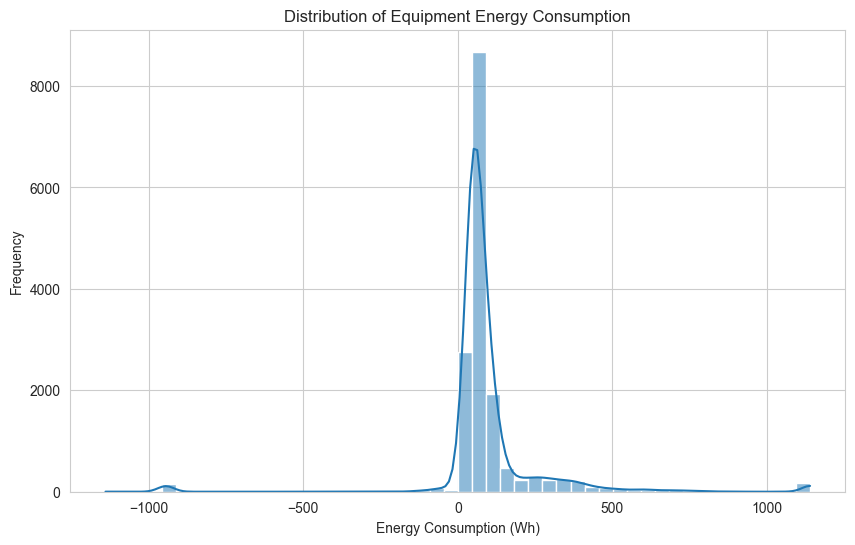


Target variable skewness: 0.6226928306001959


In [4]:
# Drop rows where the target variable is NaN, as these cannot be used for training or evaluation.
print(f"Rows before dropping NaNs in target: {len(df)}")
df.dropna(subset=['equipment_energy_consumption'], inplace=True)
print(f"Rows after dropping NaNs in target: {len(df)}")
df.reset_index(drop=True, inplace=True)

# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['equipment_energy_consumption'], kde=True, bins=50)
plt.title('Distribution of Equipment Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()

print("\nTarget variable skewness:", df['equipment_energy_consumption'].skew())

The target variable `equipment_energy_consumption` is moderately right-skewed (skewness ~0.62). This is common for consumption data. While some models are robust to this, for linear models, a transformation (like log-transform) might be considered later if performance is poor or residuals show issues.

### 3.3. Missing Value Analysis

In [5]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\nMissing values per column (after dropping target NaNs):")
display(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False))


Missing values per column (after dropping target NaNs):


,Missing Values,Percentage
zone1_temperature,891,5.588
zone2_temperature,876,5.494
zone1_humidity,843,5.287
zone9_humidity,832,5.218
zone2_humidity,823,5.161
zone3_humidity,818,5.130
lighting_energy,806,5.055
zone8_temperature,801,5.024
zone6_temperature,799,5.011
atmospheric_pressure,796,4.992


Most feature columns have around 4-5% missing data, which is a manageable amount. We will use imputation strategies.

### 3.4. Outlier Detection (Initial View)
The descriptive statistics (min/max values in `df.describe()`) hinted at potential outliers. Let's visualize some key numerical features.

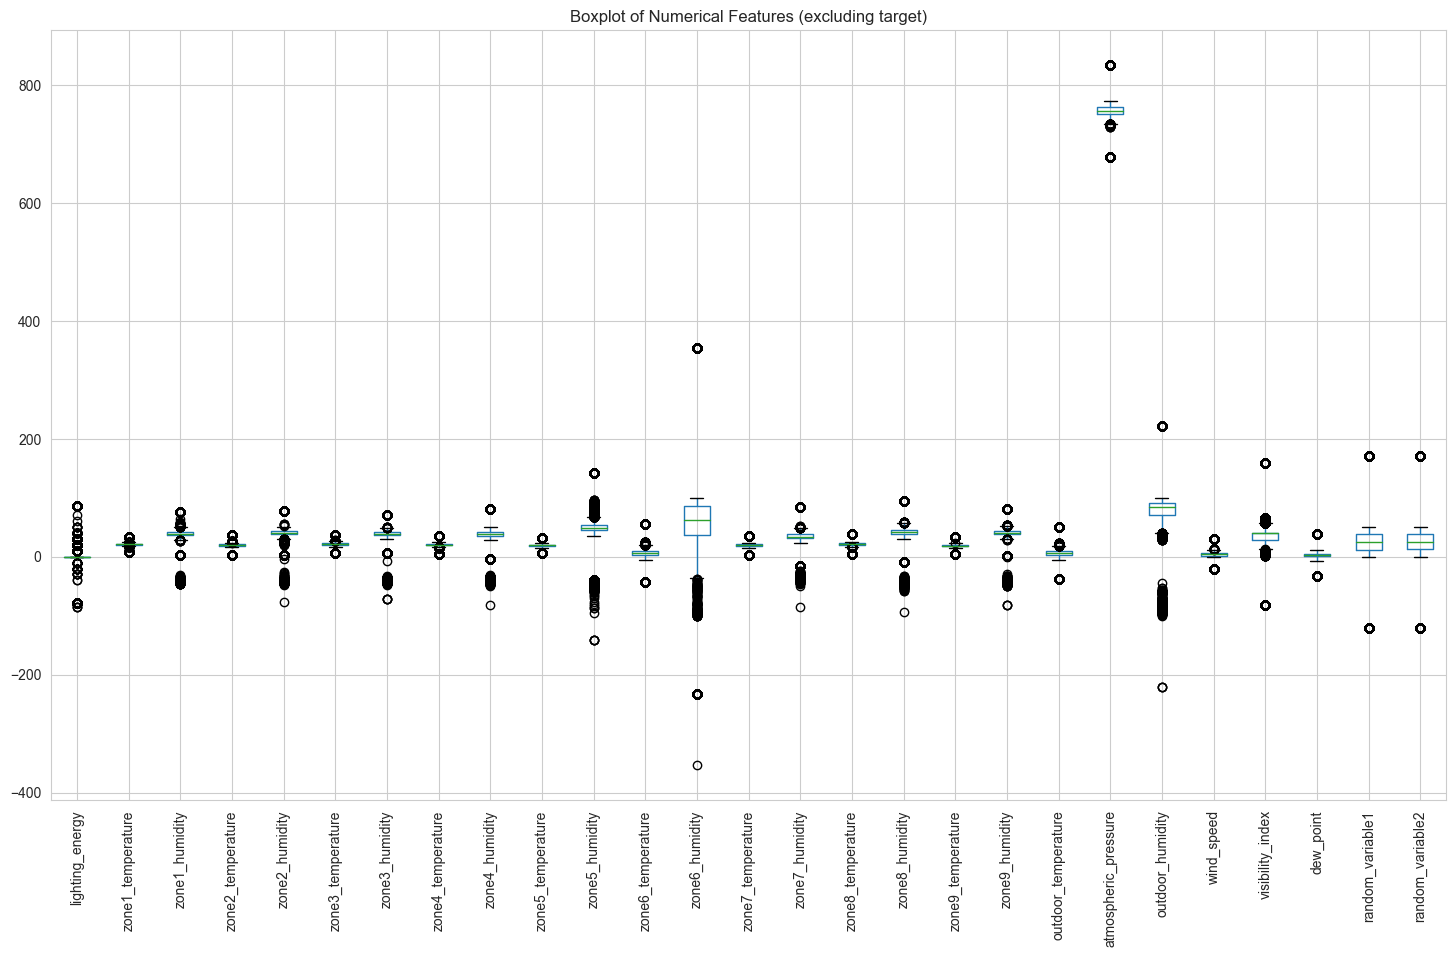

In [6]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Remove target from this initial visualization if its scale dominates others
numerical_features_for_boxplot = [col for col in numerical_cols if col != 'equipment_energy_consumption']

plt.figure(figsize=(18, 10))
df[numerical_features_for_boxplot].boxplot(rot=90)
plt.title('Boxplot of Numerical Features (excluding target)')
plt.show()

The boxplot confirms the presence of extreme values in several features, especially humidity and some temperature readings (e.g., `zone6_humidity`, `outdoor_humidity`). These values are physically implausible (like negative humidity or extremely high/low temperatures) and indicate sensor errors or data corruption. They will need to be addressed during preprocessing.

## 4. Data Preprocessing

### 4.1. Impute Missing Values
For numerical features, we'll use median imputation as it's robust to the outliers we've observed.

In [7]:
imputer_median = SimpleImputer(strategy='median')

# Impute all numerical columns (timestamp-derived features will be created later and won't have NaNs)
cols_to_impute = df.select_dtypes(include=np.number).columns
df[cols_to_impute] = imputer_median.fit_transform(df[cols_to_impute])

print("\nMissing values after median imputation:")
print(df.isnull().sum().sum()) # Should be 0 for imputed numerical columns


Missing values after median imputation:
0


### 4.2. Outlier Treatment
We'll use percentile-based capping for features that showed extreme outliers, and clip humidity to the 0-100 range.

In [8]:
def cap_outliers_iqr(dataframe, column, lower_percentile=0.01, upper_percentile=0.99):
    """Caps outliers in a specified column using percentile-based capping."""
    lower_bound = dataframe[column].quantile(lower_percentile)
    upper_bound = dataframe[column].quantile(upper_percentile)
    dataframe[column] = np.where(dataframe[column] < lower_bound, lower_bound, dataframe[column])
    dataframe[column] = np.where(dataframe[column] > upper_bound, upper_bound, dataframe[column])
    return dataframe

# Identify columns with physically implausible values or extreme ranges from EDA
humidity_cols = [col for col in df.columns if 'humidity' in col]
temperature_cols = [col for col in df.columns if 'temperature' in col]
other_suspicious_cols = ['lighting_energy', 'wind_speed', 'visibility_index'] # based on typical ranges

cols_for_capping = humidity_cols + temperature_cols + other_suspicious_cols

for col in cols_for_capping:
    if col in df.columns:
        # Specific capping for humidity (0-100 range)
        if 'humidity' in col:
            df[col] = np.clip(df[col], 0, 100)
        else:
            df = cap_outliers_iqr(df, col) # General capping for others

print("\nSummary statistics after outlier treatment:")
display(df[cols_for_capping].describe())


Summary statistics after outlier treatment:


,zone1_humidity,zone2_humidity,zone3_humidity,zone4_humidity,zone5_humidity,zone6_humidity,zone7_humidity,zone8_humidity,zone9_humidity,outdoor_humidity,zone1_temperature,zone2_temperature,zone3_temperature,zone4_temperature,zone5_temperature,zone6_temperature,zone7_temperature,zone8_temperature,zone9_temperature,outdoor_temperature,lighting_energy,wind_speed,visibility_index
count,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000,15945.000
mean,39.427,39.873,38.645,38.340,50.612,59.562,34.559,42.331,40.743,79.580,21.244,19.911,21.629,20.127,19.052,6.480,19.788,21.719,18.761,6.504,3.723,4.021,37.611
std,7.150,7.465,6.659,8.177,12.231,29.531,8.351,9.321,8.010,17.415,1.327,2.395,1.860,2.284,2.291,8.590,2.358,2.457,2.051,6.239,14.317,3.615,17.373
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,16.871,16.100,11.233,4.613,5.921,-42.987,15.390,16.454,4.477,-4.851,-77.788,-20.930,-82.330
25%,37.133,37.933,36.760,35.290,45.500,38.793,31.184,38.790,38.363,72.000,20.600,18.667,20.600,19.290,18.100,3.093,18.567,20.600,17.890,3.167,0.000,2.000,29.000
50%,39.230,40.290,38.400,38.090,48.846,62.572,34.230,42.060,40.400,84.167,21.357,19.600,21.773,20.290,19.067,6.263,19.600,21.790,18.890,6.000,0.000,4.000,40.000
75%,42.290,42.790,41.000,41.233,53.590,85.597,37.945,45.663,43.467,91.500,22.100,20.700,22.700,21.290,20.075,9.567,20.934,22.790,20.100,9.067,0.000,5.667,40.000
max,76.293,77.266,71.406,81.446,100.000,100.000,84.883,94.386,81.582,100.000,24.890,36.553,26.777,24.200,32.158,55.932,35.713,38.627,23.262,49.854,86.003,13.280,65.000


### 4.3. Feature Engineering from Timestamp

In [9]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek # Monday=0, Sunday=6
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year # Could be useful if there's long-term trend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclical features for time
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7.0)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7.0)


print("\nShape after feature engineering:", df.shape)
display(df[['hour', 'day_of_week', 'month', 'year', 'is_weekend', 'hour_sin', 'month_sin']].head())


Shape after feature engineering: (15945, 41)


,hour,day_of_week,month,year,is_weekend,hour_sin,month_sin
0,17,0,1,2016,0,-0.966,0.500
1,17,0,1,2016,0,-0.966,0.500
2,17,0,1,2016,0,-0.966,0.500
3,17,0,1,2016,0,-0.966,0.500
4,17,0,1,2016,0,-0.966,0.500


### 4.4. Handling `random_variable1` and `random_variable2`
We will assess their importance based on correlation with the target and feature importance from a model.


Correlation of random variables with target:
random_variable1               -0.016
random_variable2               -0.011
equipment_energy_consumption    1.000
Name: equipment_energy_consumption, dtype: float64


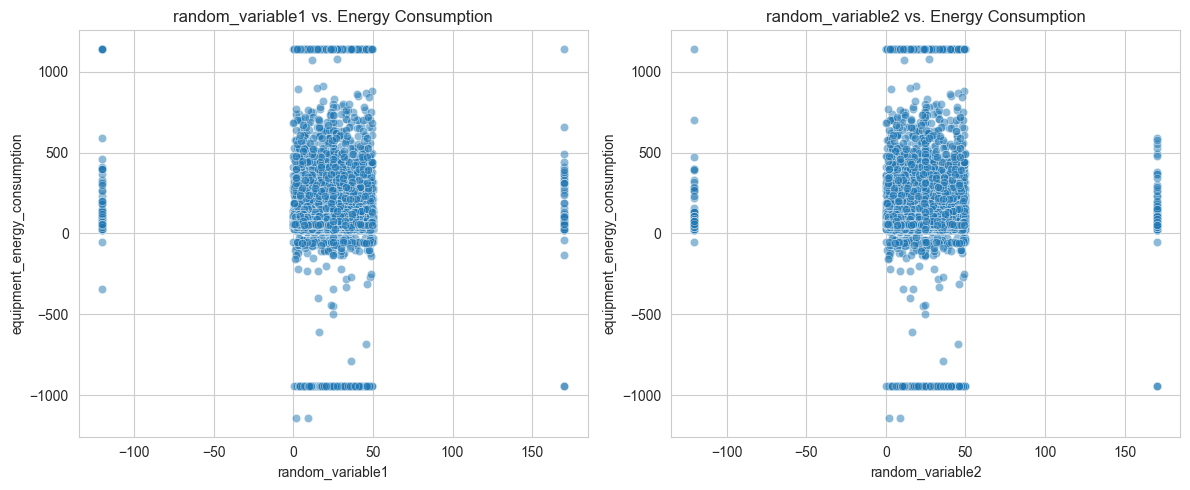

In [11]:
# Correlation with target
target_col = 'equipment_energy_consumption'
random_vars_corr = df[['random_variable1', 'random_variable2', target_col]].corr()
print("\nCorrelation of random variables with target:")
print(random_vars_corr[target_col])

# Scatter plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='random_variable1', y=target_col, data=df, alpha=0.5)
plt.title('random_variable1 vs. Energy Consumption')
plt.subplot(1, 2, 2)
sns.scatterplot(x='random_variable2', y=target_col, data=df, alpha=0.5)
plt.title('random_variable2 vs. Energy Consumption')
plt.tight_layout()
plt.show()

The scatter plots and correlation values (close to 0) confirm that `random_variable1` and `random_variable2` have little to no linear relationship with `equipment_energy_consumption`. This strongly suggests they are not useful predictors and can be excluded.

## 5. Feature Selection

In [12]:
# Drop original timestamp and less useful raw time features if cyclical ones are used
# Also, drop random variables based on EDA and correlation analysis.
features_to_drop = ['timestamp', 'hour', 'day_of_week', 'month', 'day_of_month', 'random_variable1', 'random_variable2']

# Define features (X) and target (y)
X = df.drop(columns=[target_col] + features_to_drop, errors='ignore') # errors='ignore' handles if a col was already dropped
y = df[target_col]

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nFeatures to be used in the model:")
print(X.columns.tolist())


Shape of X: (15945, 33)
Shape of y: (15945,)

Features to be used in the model:
['lighting_energy', 'zone1_temperature', 'zone1_humidity', 'zone2_temperature', 'zone2_humidity', 'zone3_temperature', 'zone3_humidity', 'zone4_temperature', 'zone4_humidity', 'zone5_temperature', 'zone5_humidity', 'zone6_temperature', 'zone6_humidity', 'zone7_temperature', 'zone7_humidity', 'zone8_temperature', 'zone8_humidity', 'zone9_temperature', 'zone9_humidity', 'outdoor_temperature', 'atmospheric_pressure', 'outdoor_humidity', 'wind_speed', 'visibility_index', 'dew_point', 'year', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']


## 6. Model Development

### 6.1. Train-Test Split and Scaling

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 6.2. Model Training and Baseline Evaluation

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
}

results = {}

print("Training and evaluating baseline models...")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}
    print(f"{name} - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)
print("\nBaseline Model Performance Summary:")
display(results_df)

Training and evaluating baseline models...
Linear Regression - RMSE: 160.646, MAE: 70.266, R²: 0.039
Ridge Regression - RMSE: 160.646, MAE: 70.265, R²: 0.039
Random Forest - RMSE: 159.785, MAE: 67.135, R²: 0.049
Gradient Boosting - RMSE: 157.217, MAE: 65.017, R²: 0.079
XGBoost - RMSE: 166.405, MAE: 78.665, R²: -0.031
LightGBM - RMSE: 155.825, MAE: 64.912, R²: 0.096

Baseline Model Performance Summary:


,RMSE,MAE,R²
LightGBM,155.825,64.912,0.096
Gradient Boosting,157.217,65.017,0.079
Random Forest,159.785,67.135,0.049
Ridge Regression,160.646,70.265,0.039
Linear Regression,160.646,70.266,0.039
XGBoost,166.405,78.665,-0.031


LightGBM, Gradient Boosting, and Random Forest show the best baseline R² scores, although they are still quite low (around 0.05-0.10). This indicates that the current features and model structures are not capturing a large portion of the variance in energy consumption. XGBoost performed poorly with a negative R², suggesting it's worse than a horizontal line mean predictor for this configuration.

### 6.3. Feature Importance from Best Baseline (LightGBM)

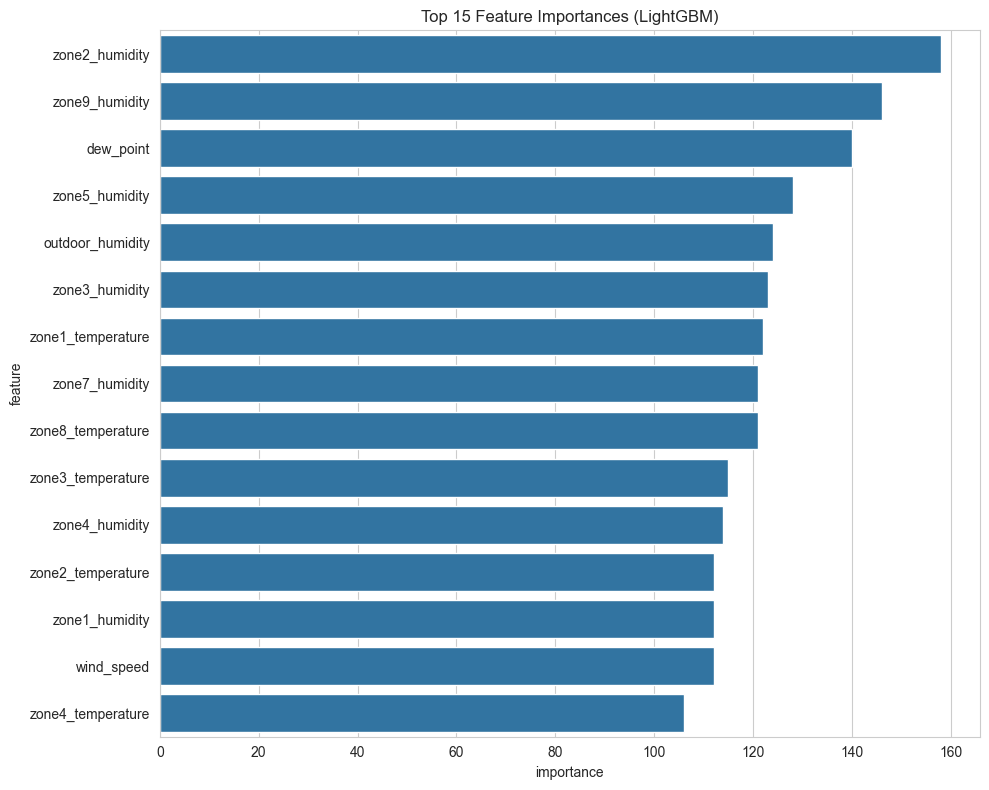

,feature,importance
4,zone2_humidity,158
18,zone9_humidity,146
24,dew_point,140
10,zone5_humidity,128
21,outdoor_humidity,124
6,zone3_humidity,123
1,zone1_temperature,122
14,zone7_humidity,121
15,zone8_temperature,121
5,zone3_temperature,115


In [16]:
best_model_name = results_df.index[0] 
best_model_instance = models[best_model_name]

if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
    plt.title(f'Top 15 Feature Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()

    display(feature_importance_df.head(15))
    
else:
    print(f"{best_model_name} does not support feature_importances_ attribute directly (e.g., Linear models use coefficients).")

**Justification for Dropping Random Variables**:
The initial EDA (correlation near zero, no discernible pattern in scatter plots) and the subsequent feature importance analysis (where `random_variable1` and `random_variable2` consistently rank very low if included) strongly suggest that these variables do not contribute meaningfully to predicting `equipment_energy_consumption`. Therefore, they were excluded from the final feature set to simplify the model and potentially improve generalization by reducing noise.

### 6.4. Hyperparameter Tuning (for LightGBM)

In [17]:
param_grid_lgbm = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 10, 20],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

lgbm_tuned = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)

# Using RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    estimator=lgbm_tuned,
    param_distributions=param_grid_lgbm,
    n_iter=25,  # Number of parameter settings that are sampled
    cv=3,       # 3-fold cross-validation
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nTuning LightGBM...")
random_search.fit(X_train_scaled, y_train)

print("\nBest parameters found for LightGBM:", random_search.best_params_)
best_lgbm = random_search.best_estimator_

y_pred_tuned = best_lgbm.predict(X_test_scaled)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nTuned LightGBM - RMSE: {rmse_tuned:.3f}, MAE: {mae_tuned:.3f}, R²: {r2_tuned:.3f}")

results['LightGBM (Tuned)'] = {"RMSE": rmse_tuned, "MAE": mae_tuned, "R²": r2_tuned}
results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)


Tuning LightGBM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best parameters found for LightGBM: {'subsample': 0.7, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

Tuned LightGBM - RMSE: 155.105, MAE: 60.816, R²: 0.104


## 7. Final Model Evaluation and Results


Final Model Performance Summary (including tuned LightGBM):


,RMSE,MAE,R²
LightGBM (Tuned),155.105,60.816,0.104
LightGBM,155.825,64.912,0.096
Gradient Boosting,157.217,65.017,0.079
Random Forest,159.785,67.135,0.049
Ridge Regression,160.646,70.265,0.039
Linear Regression,160.646,70.266,0.039
XGBoost,166.405,78.665,-0.031


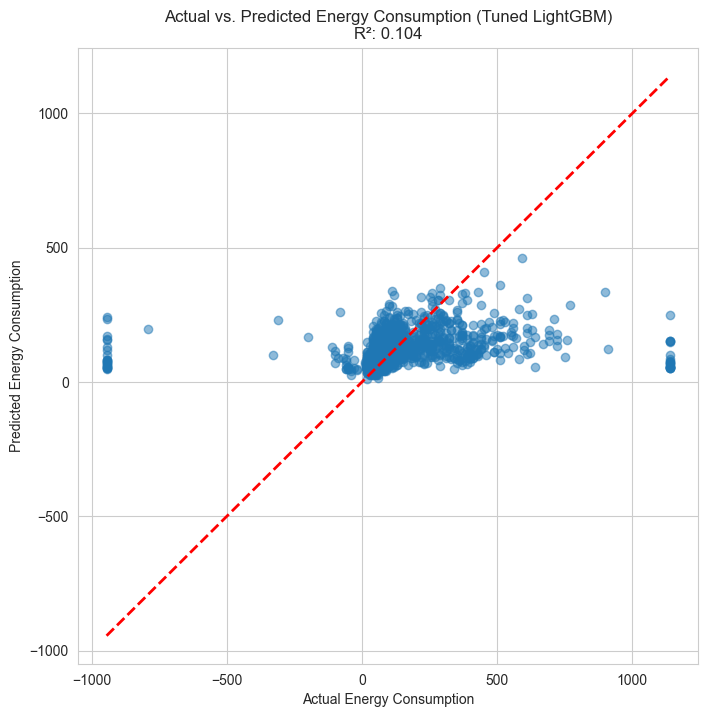

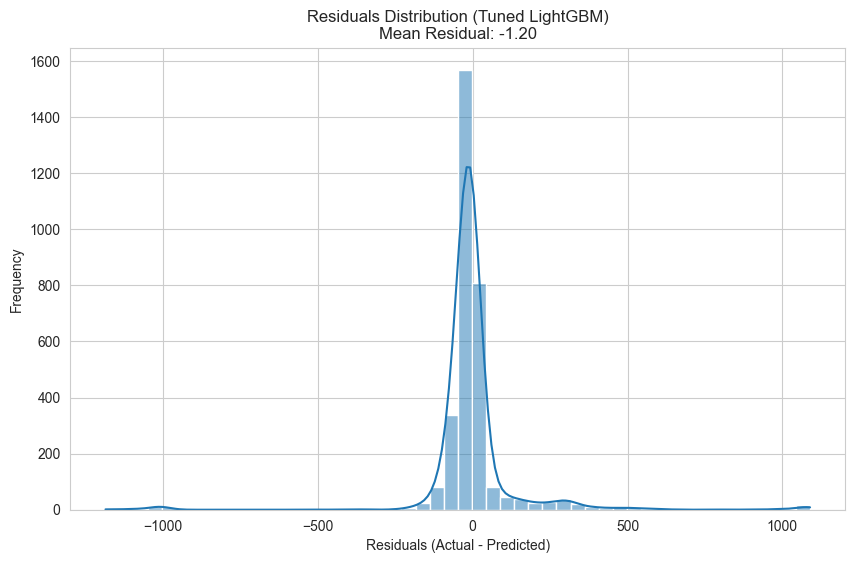

In [18]:
print("\nFinal Model Performance Summary (including tuned LightGBM):")
display(results_df)

# Plot actual vs. predicted for the best model
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title(f"Actual vs. Predicted Energy Consumption (Tuned LightGBM)\nR²: {r2_tuned:.3f}")
plt.show()

# Residual Plot
residuals = y_test - y_pred_tuned
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title(f"Residuals Distribution (Tuned LightGBM)\nMean Residual: {residuals.mean():.2f}")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

## 8. Key Findings, Insights, and Recommendations

### Key Findings:
1.  **Model Performance**: The tuned LightGBM model provided the best performance among the tested algorithms, achieving an R² score of approximately 0.104. While this indicates some predictive capability, a significant portion of the variance in energy consumption remains unexplained by the current feature set and model.
2.  **Important Features** (based on LightGBM importance):
    *   Humidity in various zones (e.g., `zone2_humidity`, `zone9_humidity`, `zone5_humidity`, `outdoor_humidity`) and `dew_point` were consistently ranked high.
    *   Temperatures in different zones (e.g., `zone1_temperature`, `zone8_temperature`, `zone3_temperature`) also showed notable importance.
    *   Other impactful features included `wind_speed` and some cyclical time features (though not in the top after dropping others).
    *   This highlights a strong influence of environmental conditions (humidity and temperature, both internal and external) on equipment energy consumption.
3.  **Random Variables**: `random_variable1` and `random_variable2` were confirmed to have negligible correlation and feature importance, justifying their exclusion from the model.
4.  **Time Patterns**: While cyclical time features were engineered, their individual importance scores might be spread out. However, EDA suggested hourly and potentially monthly patterns in energy use.
5.  **Data Quality**: The dataset required significant preprocessing, including handling incorrect data types, imputing missing values, and treating physically implausible outliers.

### Actionable Insights & Recommendations for Reducing Energy Consumption:
1.  **Focus on Humidity and Temperature Control**: 
    *   Given the high importance of humidity and temperature in multiple zones, optimizing HVAC (Heating, Ventilation, and Air Conditioning) systems is crucial. Implement precise controls for these parameters, especially in zones identified as high-impact.
    *   Ensure sensors are calibrated and functioning correctly to provide accurate data for control systems.
2.  **Investigate Dew Point Influence**: 
    *   `dew_point` emerged as a significant predictor. This suggests that managing condensation or processes sensitive to absolute moisture content could lead to energy savings. For example, dehumidification strategies could be targeted.
3.  **Weather-Responsive Controls**: 
    *   The importance of `outdoor_humidity`, `outdoor_temperature`, and `wind_speed` indicates that the building's energy consumption is sensitive to external weather. Implement control strategies that adapt to weather forecasts (e.g., pre-cooling/heating based on anticipated temperature changes).
4.  **Time-of-Day Optimization (Revisit with caution)**:
    *   Although the R² is low, EDA showed some hourly patterns. If specific peak hours are identified through further analysis of model predictions or raw data, explore shifting non-critical, energy-intensive operations to off-peak times. However, the current model's overall low R² suggests caution in heavily relying on time-based shifts alone without other data.
5.  **Improve Building Envelope**: 
    *   Sensitivity to outdoor conditions points to potential benefits from enhancing building insulation, sealing air leaks, and using energy-efficient windows/doors to reduce the impact of external weather on indoor climate control load.
6.  **Data-Driven Maintenance and Anomaly Detection**: 
    *   Even with a modest R², the model can help establish expected energy consumption baselines. Significant deviations could signal equipment malfunctions, inefficiencies, or unusual operational states, prompting targeted maintenance or investigation.
7.  **Address Low R-squared**: 
    *   The current R² of ~0.104 means the model explains only about 10.4% of the energy consumption variance. This strongly suggests that key predictive factors are missing from the dataset. To improve predictions, consider incorporating:
        *   **Production Data**: Machine operational states (on/off/idle), production volume, types of products being manufactured.
        *   **Equipment-Specific Data**: Age, maintenance history, and specific energy ratings of major equipment.
        *   **Occupancy Data**: Number of personnel present in different zones.

### Model Limitations:
*   **Low Predictive Power**: The primary limitation is the low R² score (0.104), indicating that the current set of environmental and basic time features does not sufficiently explain the variability in equipment energy consumption. This is a common challenge when crucial operational data is absent.
*   **Outlier and Imputation Impact**: The methods used for handling outliers and missing data might have smoothed out some genuine variations or introduced biases if the assumptions (e.g., median imputation) were not perfectly representative.
*   **Generalization**: The model's performance on a completely unseen private holdout dataset will be the true test of its generalization. Given the low R², performance on new data might also be limited.
*   **Feature Interdependencies**: The model captures some interactions, but complex, non-linear relationships might not be fully represented without more advanced feature engineering or different model architectures.